# DS Series : Estimasi kerusakan mesin berdasarkan jam operasi 
---
project kali ini saya membuat sebuah portofolio data science untuk prediksi dan estimasi penjadwalan perbaikan mesin industri berdasarkan jam operasinya dengan data yang didapatkan secara dummy

<ul>
    <li><b>Portofolio Data Science Series</b></li> 
    <li>Episode 1 : Prediksi dan Estimasi</li>
</ul>

>  Alan Firdaus 

Data Wrangling
---
pada bagian pertama ini mulai dari data preparation yaitu menyiapan datasheet yang akan digunakan dalam portofolio ini. Pada tahap ini juga kita akan mulai dari load datasheet yang digunakan hingga pengecekan apakah ada fitur pada dataheet yang memiliki nilai missing value 

Load Datasheet & Import Library
---

In [40]:
# Import library yang akan digunakan 
import numpy as np              # library untuk komputasi numerik dengan python 
import pandas as pd             # library untuk pengolahan dataframe 
import matplotlib.pyplot as plt # library untuk visualisasi data 
import seaborn as sns           # library untuk visualisasi data 

import warnings                 # library untuk handling error 
import seaborn as sns           # library untuk visualisasi data 
import os

# buat variabel untuk mengelola error pada saat proses komputasi 
warnings.filterwarnings('ignore')

# load- datasheet yang akan diguanakan 
df_mtn_machine = pd.read_csv('./datasheet/maintenance_machine_data.csv')

# tampilkan isi dari datasheet yang sudah di import
print(df_mtn_machine)

      Jam_Operasi  Suhu_Motor  Getaran  Tekanan_Oli  Arus_Listrik  \
0            7770       76.92     3.66         2.77          8.54   
1            1360       82.86     2.61         2.48          8.49   
2            5890       78.05     3.47         3.02         10.96   
3            5691       79.30     1.35         3.80          7.62   
4            6234       70.40     2.64         2.82          9.35   
...           ...         ...      ...          ...           ...   
1195         3504       74.60     2.56         3.75          7.77   
1196         5636       80.85     2.46         2.92          6.84   
1197          829       74.90     2.13         2.94          7.88   
1198         4140       82.14     1.67         3.07          5.79   
1199         8482       61.32     2.51         2.67          5.66   

      Umur_Sisa_Mesin  
0             1935.07  
1             1997.03  
2             1912.03  
3             1838.49  
4             1943.79  
...               ...  
119

<b>Insight : </b>
<p>dari datasheet tersebut dapat kita ketahui bahwa sebagian besar memiliki tipe data numerik dan memiliki 6 kolom dan 1200 baris</p>

Cek Duplikasi dan missing value pada datasheet 
---
setelah kita mengetahui jumlah kolom dan baris serta tipe data pada dataframe yang sudah di load maka selanjutnya kita akn mencoba mencari tahu apakah data kita memiliki missing value ataupun nilai yang duplikat 

In [41]:
# buat kode program untuk mengecek duplikasi dan missing value 
print(f"Duplikasi pada dataframe tersebut berjumlah {df_mtn_machine.duplicated().sum().sum()} data")
print(f"Jumlah missing value pada dataframe tersbeut berjumlah {df_mtn_machine.isnull().sum().sum()} data")

Duplikasi pada dataframe tersebut berjumlah 0 data
Jumlah missing value pada dataframe tersbeut berjumlah 0 data


<b>Insight :</b>
<p>Nah pada poin 1.2 kita dapat mengetahui bahwa datasheet yang kita gunakan tidak memiliki missing value sehingga kita bisa lanjut pada tahap analisis eksplorasi data</p>

Exploratory Data Analyst (EDA)
---
Di bagian poin nomor 2 ini kita akan melakukan analisis eksplorasi data lebih lanjut untuk mengetahui insight apa saja yang bisa didapatkan dari hasil analisis tersebut serta mencari insight yang bisa bermanfaat untuk kedepan nya. 

Dibagian ini akan dibagi dalam 2 section yaitu : 
<ul>
    <li>1.Data Manipulation : digunakan untuk memanipulasi data dengan metode statistik</li>
    <li>2.Eksplorasi data : digunakan untuk mencari insight dari data yang bermanfaat untuk kedepan nya</li>
</ul>

Data Manipluation Section 
---
padan bagian ini kita akan melakukan analisis untuk mengetahui apakah datasheet yang kita gunakan sudah bersih dari nilai outlier atau pun melihat pesebaran distribusi normal dari setiap fitur beserta korelasi nya

Pengecekan Outlier dengan menggunakan visualisasi Boxplot dan IQR
---
penting untuk mengetahui apakah pada data benar-benar aman dari nilai outlier karena bisa mempengaruhi model saat melaukan tuning yang menyebabkan model menjadi tidak akurat dan bias sehingga untuk menghindari kondisi ini penting untuk melakukan pengecekan outlier pada smeua fitur yang ada pada datasheet 

Buat class oop untuk bagian section data manipulation
---
<p>karena proses EDA ini lama maka kita akan membuat sebuah program oop agar code tersebut bisa dijalankan berulang kali tanpa harus menulis ulang code dari awal yang dimana ini akan menghemat waktu </p>

In [42]:
class data_manipulation:
    def __init__(self, data, features, cols=4, rows=2, figsize=(10, 4), palette='rocket'):
        # Inisialisasi parameter dan data
        self.data = data.copy()  # gunakan salinan untuk menjaga data asli tetap aman
        self.features = features
        self.cols = cols
        self.rows = rows
        self.figsize = figsize
        self.palette = palette

    def detect_outliers(self, series):
        """
        Menghitung dan mengembalikan nilai outlier pada sebuah kolom (series) 
        menggunakan metode IQR (Interquartile Range).
        """
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return series[(series < lower) | (series > upper)]

    def count_outliers(self):
        """
        Menghitung jumlah outlier untuk setiap fitur dan total keseluruhan dalam bentuk dictionary.
        """
        outlier_counts = {}
        total_outliers = 0

        for feature in self.features:
            if feature in self.data.columns:
                outliers = self.detect_outliers(self.data[feature])
                count = outliers.count()
                outlier_counts[feature] = count
                total_outliers += count
            else:
                outlier_counts[feature] = 'Fitur tidak ditemukan'

        outlier_counts['Total_Outliers'] = total_outliers
        return outlier_counts

    def count_outliers_df(self):
        """
        Menghitung jumlah outlier untuk setiap fitur dan mengembalikannya dalam bentuk DataFrame.
        """
        records = []

        for feature in self.features:
            if feature in self.data.columns:
                outliers = self.detect_outliers(self.data[feature])
                records.append({
                    'Fitur': feature,
                    'Jumlah Outlier': outliers.count()
                })
            else:
                records.append({
                    'Fitur': feature,
                    'Jumlah Outlier': 'Fitur tidak ditemukan'
                })

        return pd.DataFrame(records)

    def remove_outliers(self):
        """
        Menghapus baris pada data yang mengandung outlier untuk fitur-fitur yang ditentukan.
        Menggunakan metode IQR.
        """
        cleaned_data = self.data.copy()

        for feature in self.features:
            if feature in cleaned_data.columns:
                q1 = cleaned_data[feature].quantile(0.25)
                q3 = cleaned_data[feature].quantile(0.75)
                iqr = q3 - q1
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr
                # filter data untuk hanya menyimpan nilai dalam rentang normal
                cleaned_data = cleaned_data[(cleaned_data[feature] >= lower) & (cleaned_data[feature] <= upper)]
        
        return cleaned_data

    def plot(self):
        """
        Menampilkan visualisasi boxplot untuk setiap fitur dengan anotasi outlier 
        dan background yang berubah jika terdapat outlier.
        """
        fig, axes = plt.subplots(self.rows, self.cols, figsize=self.figsize)
        axes = axes.flatten()

        for i, feature in enumerate(self.features):
            if feature not in self.data.columns:
                axes[i].text(0.5, 0.5, f"{feature}\ntidak ditemukan", 
                             horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes[i].axis('off')
                continue

            ax = axes[i]
            sns.boxplot(x=self.data[feature], ax=ax, color=sns.color_palette(self.palette)[0])
            ax.set_title(f'Boxplot: {feature}')

            outliers = self.detect_outliers(self.data[feature])

            if not outliers.empty:
                for y in outliers:
                    ax.axvline(x=y, color='red', linestyle='--', alpha=0.5)
                ax.set_facecolor("#fce4e4")
            else:
                ax.set_facecolor("#f4f4f4")

        for j in range(len(self.features), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

<h5>Note :</h5><p>setelah program oop untuk bagian case data maniputaion berhasil untuk di buat maka selanjutnya kita akan memanggil instance yang sudah dibuat untuk keperluan analisis</p>

Analisis nilai outlier dengan menggunakan visualisasi boxplot 
---
pada bagian ini kita akan mengguanakan instance yang sudah kita buat

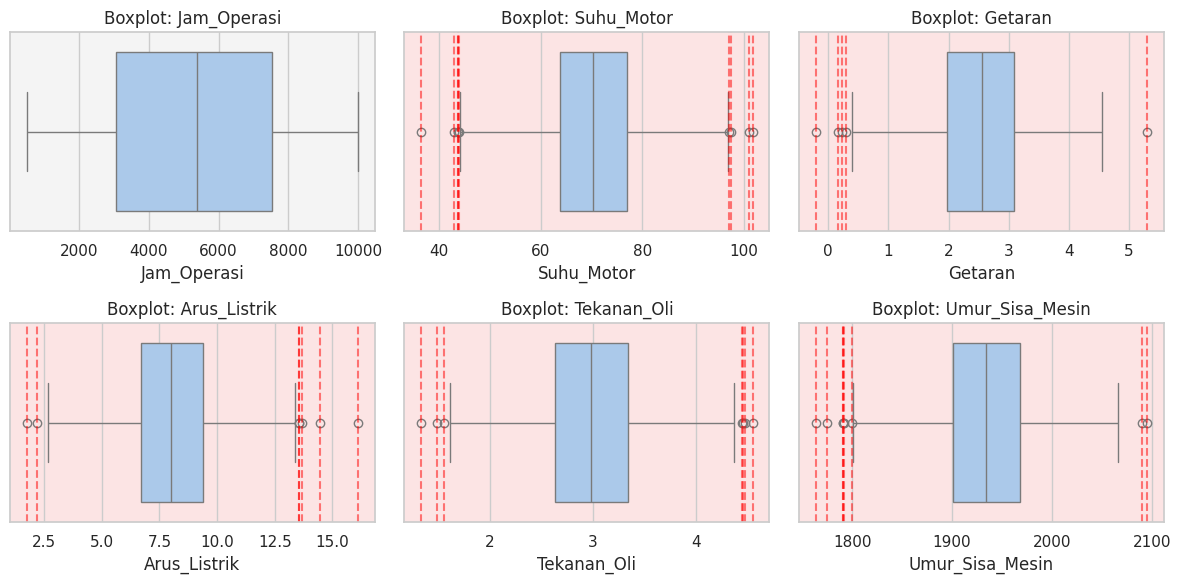

In [43]:
# Daftar fitur yang akan dicek untuk outlier
fitur_boxplot = ['Jam_Operasi', 'Suhu_Motor', 'Getaran', 'Arus_Listrik','Tekanan_Oli','Umur_Sisa_Mesin']

# Buat objek visualizer dengan parameter data dan konfigurasi subplot
visualizer = data_manipulation(df_mtn_machine, fitur_boxplot, cols=3, rows=2, figsize=(12, 6), palette="pastel")

# Tampilkan visualisasi boxplot beserta outlier-nya
visualizer.plot()

dari hasil visualisasi tersebut diketahui bahwa terdapat 5 kolom yang memiliki nilai outlier sehingga kita perlu memproses error tersebut dengan teknik IQR tapi sebelum itu perlu untuk mengetahui berapa jumlah data yang memiliki nilai outlier.

<b>Note :</b>
fitur yang memiliki outlier ditandai dengan background berwarna merah muda dengan anotasi garis

B.Jumlah outliers pada masing masing fitur 
---
setelah kita mengetahui bahwa ternayata terdapat beberapa fitur yang terdeteksi memiliki nilai outliers 

In [44]:
# Hitung outlier dan tampilkan sebagai DataFrame
df_outliers = visualizer.count_outliers_df()
print(df_outliers)
print('\n ternyata terdapat beberapa fitur data yang memiliki nilai outliers terutama pada kolom umur sisa mesin yang berjumlah 8 data')

             Fitur  Jumlah Outlier
0      Jam_Operasi               0
1       Suhu_Motor               9
2          Getaran               5
3     Arus_Listrik               7
4      Tekanan_Oli               7
5  Umur_Sisa_Mesin               8

 ternyata terdapat beberapa fitur data yang memiliki nilai outliers terutama pada kolom umur sisa mesin yang berjumlah 8 data


#### C.Menghilangkan nilai outliers dengan perhitungan IQR
---
pada tahap ini kita akan mencoba untuk menghilangkan nilai outliers yang terdeteksi dengan menggunakan perhitungan IQR tapi jika ternayat masih ada beberapa data yang memiliki nilai outlier maka kita akan mencoba teknik lain dengan menggunakan winsorize dari library scipy atau z-score

<p><b>Berikut ini adalah tahapan yang akan dilakukan pada proses ini : </p>
    
<li> - Menghilangkan nilai outlier</li> 
<li> - Menampilkan visualisasi setelah handling outlier dengan teknik IQR</li>

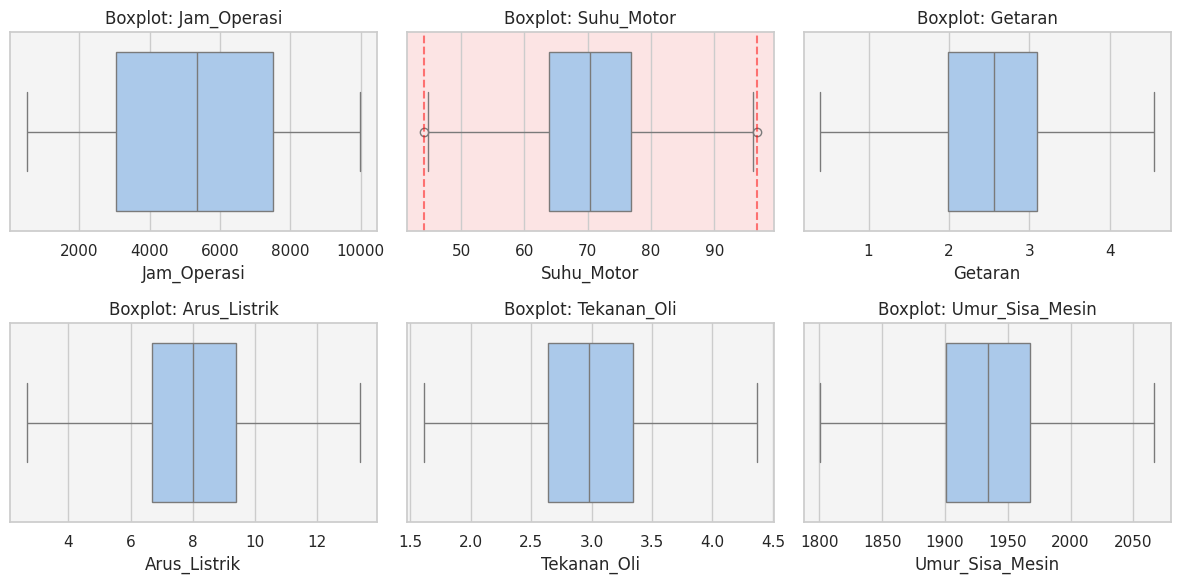

1.Data sebelum dibersihkan:, (1200, 6)
2.Data setelah outlier dihapus:, (1164, 6)
3.ternyata masih terdapat 1 data yang memiliki nilai outliers sehingga kita perlu menangani nya dengan teknik z-score


In [45]:
# Inisialisasi class seperti biasa
visualizer = data_manipulation(df_mtn_machine, fitur_boxplot, cols=2, rows=2, figsize=(12, 6), palette="pastel")

# Dapatkan data yang sudah dihapus outlier-nya
df_cleaned = visualizer.remove_outliers()

# Buat objek visualizer dengan parameter data dan konfigurasi subplot
visualizer = data_manipulation(df_cleaned, fitur_boxplot, cols=3, rows=2, figsize=(12, 6), palette="pastel")

# Tampilkan visualisasi boxplot beserta outlier-nya
visualizer.plot()

# Lihat hasil
print(f"1.Data sebelum dibersihkan:, {df_mtn_machine.shape}")
print(f"2.Data setelah outlier dihapus:, {df_cleaned.shape}")
print("3.ternyata masih terdapat 1 data yang memiliki nilai outliers sehingga kita perlu menangani nya dengan teknik z-score")

Tahap selanjutnya adalah melakukan analisis distribusi dan uji normalitas data untuk mengetahui apakah data yang sudah di proses memiliki distribusi ataupun normalitas yang baik sehingga kita bisa menggunakan nya untuk keperluan membuat model machine learning

Menghapus nilai yang masih memiliki outlier dengan teknik winsorize 
---
pada tahap ini kita akan mencoba untuk menemukan fitur yang masih memiliki nilai outlier dan mengtasi nya dengan teknik winsorize agar semua datanya clean dari nilai yang outliers 

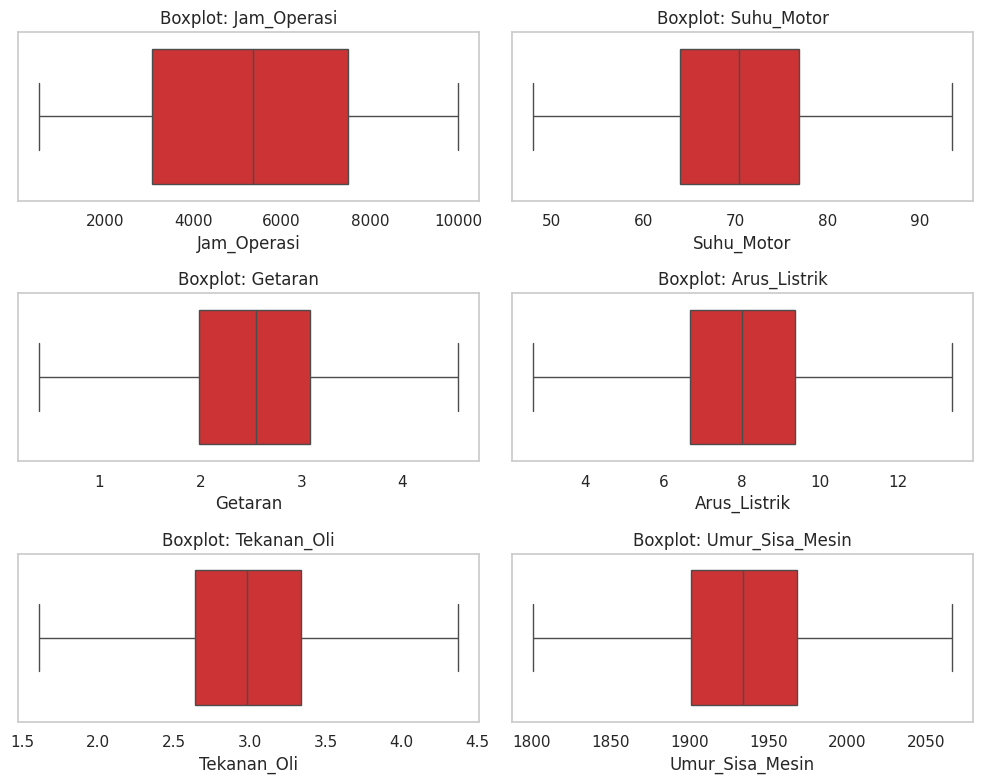

In [46]:
from scipy.stats.mstats import winsorize

# Winsorize 1% di kedua sisi (optional: kamu bisa ubah batasnya)
df_cleaned['Suhu_Motor'] = winsorize(df_cleaned['Suhu_Motor'], limits=[0.01, 0.01])

# buat function untuk menampilkan keseluruhan visualisasi boxplot yang sudah di prorocessing 
def plot(data, features, figsize=(10, 8), palette='Set2', rows=2, cols=3):
    """
    Menampilkan visualisasi boxplot untuk setiap fitur dengan anotasi outlier 
    dan background yang berubah jika terdapat outlier.
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        if feature not in data.columns:
            axes[i].text(0.5, 0.5, f"{feature}\ntidak ditemukan", 
                         horizontalalignment='center', verticalalignment='center', fontsize=12)
            axes[i].axis('off')
            continue

        ax = axes[i]
        sns.boxplot(x=data[feature], ax=ax, color=sns.color_palette(palette)[0])
        ax.set_title(f'Boxplot: {feature}')
        ax.grid(False)

    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Fitur yang ingin dianalisis
fitur = ['Jam_Operasi', 'Suhu_Motor', 'Getaran', 'Arus_Listrik','Tekanan_Oli','Umur_Sisa_Mesin']

# Panggil fungsi plot
plot(data=df_cleaned, features=fitur, figsize=(10, 8), palette='Set1', rows=3, cols=2)

Analisis Distribusi dan pengujian normalitas data 
---
pada poin 2.1.2 ini kita akan melakukan analisis untuk melihat distribusi dan normalitas data untuk semua fitur yang akan digunakan untuk keperluan model machine learning serta untuk menemukan insight yang bisa kita gunakan sebagai bahan analisis

Distribusi Normal dengan KDE dan PDF Serta Visualisasi data
---
pada tahap ini kita buat sebuah program oop untuk pengujian distribusi normal dan uji normalitas data

In [47]:
# import library yang dibutuhkan 
from scipy.stats import norm, shapiro
from statsmodels.distributions.empirical_distribution import ECDF

class DistribusiUjiNormalitas:
    def __init__(self, data, feature, figsize=(16, 4), palette='bright'):
        self.data = data
        self.feature = feature
        self.figsize = figsize
        self.palette = palette

        # Ambil array datanya
        self.values = self.data[self.feature].dropna().values

        # Uji normalitas (sekali saja di awal)
        self.stat, self.p = shapiro(self.values)
        self.is_normal = self.p =  0.05

    def _label_normalitas(self):
        if self.is_normal:
            return f"Normal (p = {self.p:.4f})"
        else:
            return f"Not Normal (p = {self.p:.4f})"

    def plot_distributions(self):
        fig, axes = plt.subplots(1, 4, figsize=self.figsize)
        sns.set_palette(self.palette)

        # Histogram
        sns.histplot(self.values, bins=20, kde=False, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Histogram\n{self._label_normalitas()}')

        # KDE Plot
        sns.kdeplot(self.values, ax=axes[1], fill=True, color='lime')
        axes[1].set_title(f'KDE\n{self._label_normalitas()}')

        # PDF (Normal Distribution Curve)
        mu, std = np.mean(self.values), np.std(self.values)
        x = np.linspace(mu - 4*std, mu + 4*std, 100)
        y = norm.pdf(x, mu, std)
        axes[2].plot(x, y, color='orange')
        axes[2].fill_between(x, y, alpha=0.3, color='orange')
        axes[2].set_title(f'PDF Normal Fit\n{self._label_normalitas()}')

        # ECDF Plot
        ecdf = ECDF(self.values)
        axes[3].plot(ecdf.x, ecdf.y, marker='.', linestyle='none', color='magenta')
        axes[3].set_title(f'ECDF\n{self._label_normalitas()}')

        # Tambahan layout
        for ax in axes:
            ax.grid(True)
            ax.set_xlabel(self.feature)
            ax.set_ylabel('Density / Probability')

        plt.tight_layout()
        plt.show()

Uji normalitas dan juga distribusi untuk fitur suhu motor 
---
pada bagian ini kita akan melakukan uji normalitas dan juga distribusi data untuk kolom fitur suhu motor 

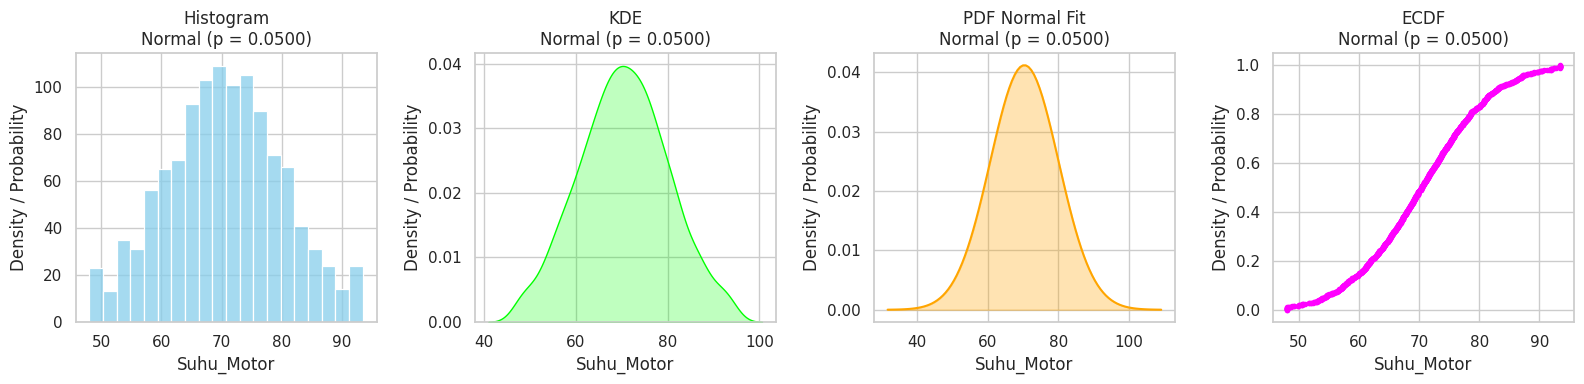

In [48]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Suhu_Motor')
visual.plot_distributions()

<b>Insight : </b>
dari hasil insight tersbeut dapat diketahui bahwa fitur suhu motor memiliki distribusi normal yang baik untuk Histogram, KDE, PDF Normal Fit lalu ECDF yang bisa kita simpulkan bahwa untuk fitur ini sudah cukup baik.

dan dari grafik histogram nya bisa kita asumsikan bahwa suhu motor rata-rata pada saat operasi produksi berlangsung ada di rentang 60 - 70 sehingga kita asumsikan bahwa ini adalah suhu normal pada motor dengan frekuensi kemunculan sekitar 120 kali 

Uji normalitas dan juga distribusi untuk fitur getaran 
---
pada bagian ini kita akan melakukan uji normalitas dan juga distribusi data untuk kolom fitur getaran

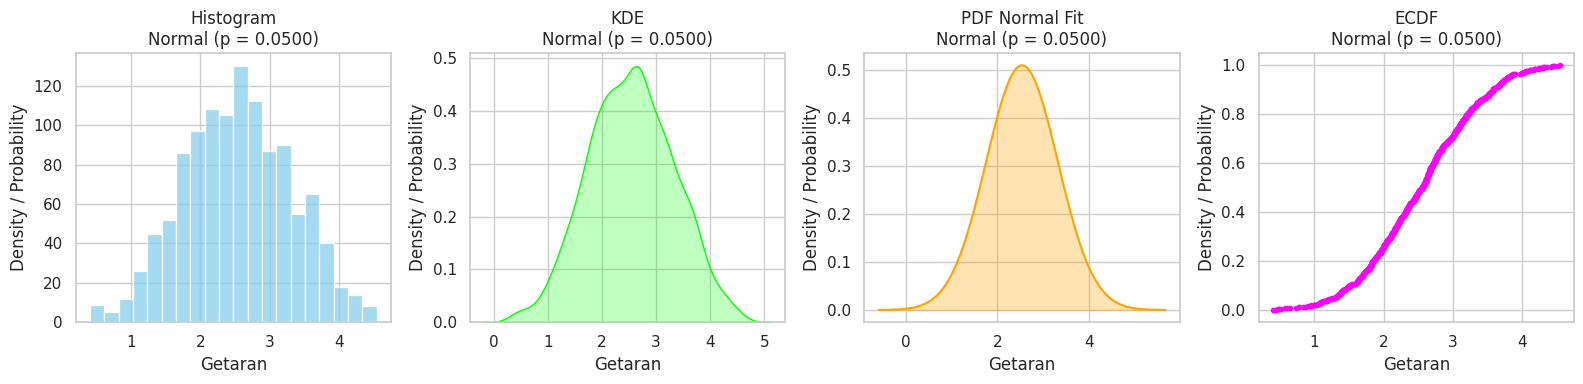

In [49]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Getaran')
visual.plot_distributions()

<b>Insight : </b>
dari hasil output berikut diketaui bahwa pada fitur getaran memiliki distribusi yang tidak normal dengan nilai p value : lebih dari 0.0005 yang bisa kita simpulkan bahwa H0 ditolak dan H1 diterima.

pada fitur getaran ini bisa kita ketahui bahwa getaran tertinggi dari mesin ada di angka 121 untuk probabilitas nya dan untuk nilai getaran nya sekitar 2 sampai dengan mendekati 3 untuk kondisi ekstrem nya  

Uji normalitas dan juga distribusi data untuk jam operasi
---
pada bagian ini kita akan menganalisis distribusi data untuk fitur jam operasi 

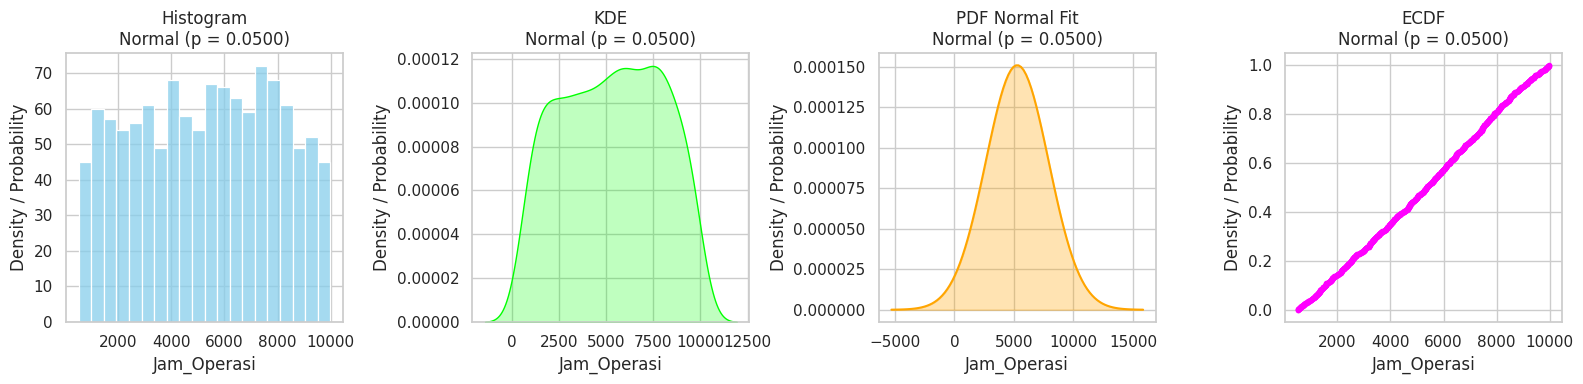

In [50]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Jam_Operasi')
visual.plot_distributions()

<b>Insight :</b>
Nah untuk jam operasi bisa kita simpulkan bahwa fitur ini tidak memiliki distribusi normal an nilai p value nya sangat ekstrem yaitu bernilai 0 yang menunjukan adanya anomali pada bagian fitur ini dan kita akan mencari tahu kenapa penyebab nya serta dari grafik histogram yang didapat bisa kita ambil kesimpulan bahwa rata-rata operasi produksi ada selalu ada di sekitar 8000 jam yang menunjukan ini adalah ambang batas dari proses produksi yang berlangngsung dengan frekuensi kemunculan sekitar 72.

dan pada grafik tersebutb jika dapat diketahui bahwa jam operasi paling sedikit ada di angka 2000 jam dengan probabilitas nya sekitar 42 % bisa jadi pada jam operasi ini mesion mengalami overheat dan perlu untuk dilakukan pemeriksaan ulang.

dan setelah mesin dipakai sekitar 4000 jam terjadi penurunan angka produksi yang mengindenfikasikan bahwa setelah mesin digunakan untuk produksi tekniksi dan juga engineer akan memeriksa ulang mesin sebelum dipakai untuk produksi mencapai angka 8000 jam 

Uji normalitas dan juga distribusi data untuk Arus Listrik
---

In [ ]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Arus_Listrik')
visual.plot_distributions()

<b>Insight</b>
dari hasil grafik yang didapat bisa kita ambil kesimpulan bahwa pada awal nya terjadi lonjakan arus listrik pada saat produksi sedang berlangsung dengan rata-rata arus listrik yang terpakai sekitar 8 dengan frekuensi kemunculan 130 kali yang menunjukan bahwa ada lonjakan arus listrik yang tinggi dan setelah itu mesin kemungkinan mengalami penurunan peforma seiring dengan waktu.

Uji normalitas dan juga distribusi data untuk kolom tekanan oli
---

In [ ]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Tekanan_Oli')
visual.plot_distributions()

<b>Insight : </b>
dari hasil visualisasi diatas bisa kita simpulkan bahwa pada saat mesin beropasi pada peforma tinggi ada kerugian energi akibat dari gesekan antar elemen mesin yang mengakibatkan ada nya rugu-rugi energi yang menyebabkan mesin menjadi panas pada komponen yang berputar sehingga meningkatkan tekanan oli untuk mendinginakn komponen  yang panas puncak nya adalah ada di sekitar 2.8 sampai dengan 3.2 ada kenaikan bertahap pada tekanan oli lalu penurunan setelah nya  

Uji normalitas dan juga distribusi data untuk umur sisa mesin
---

In [ ]:
# Contoh Data (misalnya df_mtn_machine)
visual = DistribusiUjiNormalitas(df_cleaned, 'Umur_Sisa_Mesin')
visual.plot_distributions()


<b>Insight :</b>
untuk kolom ini dapat diketahui bahwa sisa umur mesin paling optimal ada di angka 1900 dengan probabilitas sekitar 120 yang menunjukan bahwa ada kemungkinan mesin yang sudah di perbaiki akan ada penurunan umur mesin seiring dengan berjalan nya waktun sehingga mungkin teknisi dan juga engineer harus melakukan pergantian suku cadang dan juga inspeksi rutin  

Analisis Korelasi data dengan barplot
---
pada bagian ini kita akan mencari tahu korelasi apa saja dari setiap fitur pada datasheet yang kita gunakan yang bisa kiota pakai untuk analisis menggunakan linear sebagai opsi pertama dan menggunakan model yang tahan terhadap nilai outlier serta distribusi daata yang tidak normal

In [ ]:
# Ambil hanya fitur numerik
features = ['Jam_Operasi', 'Suhu_Motor', 'Getaran', 'Arus_Listrik', 'Tekanan_Oli']
target = 'Umur_Sisa_Mesin'

# Hitung korelasi
correlations = df_cleaned[features + [target]].corr(method='spearman')[target].drop(target)

# Buat DataFrame korelasi dan kategorisasi kekuatan korelasi
correlation_df = pd.DataFrame(correlations)
correlation_df.columns = ['Korelasi']
correlation_df['Kategori'] = pd.cut(correlation_df['Korelasi'],
                                     bins=[-1, -0.7, -0.3, 0.3, 0.7, 1],
                                     labels=['Kuat Negatif', 'Sedang Negatif', 'Lemah/Tidak Ada', 'Sedang Positif', 'Kuat Positif'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_df.index, y='Korelasi', data=correlation_df, hue='Kategori', palette='coolwarm')
plt.title("Korelasi Fitur terhadap Umur Sisa Mesin")
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Koefisien Korelasi (r)")
plt.xticks(rotation=45)
plt.legend(title='Tingkat Korelasi')
plt.tight_layout()
plt.show()

# Tampilkan dataframe korelasi
print(correlation_df.sort_values("Korelasi", ascending=False))

<b>insight : </b>
dari hasil visualisasi diatas ternyata data kita tidak memiliki korelasi yang kuat satu sama lain yang membuat bagian ini sulit di analisis dengan menggunakan regresi linear karena lemah nya korelasi antara satu sama lain tapi kita akan menggunakan model alternatif lain untuk yaitu menggunakan model XGBoost yang tahan terhadap outlier dan distribusi data tidak normal

Statistik deskriptif
---
pada bagian 2.2 kita akan melakukan analisis statistik deskriptif untuk mengetahui insight apa saja yang bisa di dapatkan sehingga bisa dijadikan informasi tambahan yang mungkin aja bisa membantu engineer dan juga juga tekniksi kedepan nya 

<h3>Mencari hubungan pengaruh panas dengan semua variabel yang ada pada datasheet</h3>
pada bagian 2.2.1 ini kita akan mulai dengan mencari tahu apakah kenaikan pada suhu motor sebanding dengan lama nya jam operasi 

Analisis Pengaruh Panas dan visualisasi
---
kita akan mulai dari mencari tahu pengaruh panas opada motor / pompa yang digunakan 

In [ ]:
# buat dataframe baru dari dataframe yang sudah di process sebelumnya 
df_heat = df_cleaned.copy()
df_heat['Bin_Suhu_Motor'] = pd.cut(df_heat["Suhu_Motor"], bins=5)

# Groupby dan aggregasi untuk melihat tren suhu tinggi
agg_suhu = df_heat.groupby("Bin_Suhu_Motor")[["Jam_Operasi", "Getaran", "Tekanan_Oli"]].agg(["mean", "std", "count"])
agg_suhu = agg_suhu.sort_index(ascending=False)

# Salin hasil agregasi
styled_agg_suhu = agg_suhu.copy()

# Styling fungsi untuk highlight nilai maksimum atau minimum tertentu
def highlight_critical(val, colname, mode="max"):
    if mode == "max":
        return 'color: red; font-weight: bold;' if val == styled_agg_suhu[colname].max() else ''
    elif mode == "min":
        return 'color: red; font-weight: bold;' if val == styled_agg_suhu[colname].min() else ''
    else:
        return ''

# Terapkan styling menggunakan Styler
styled = styled_agg_suhu.style

# Highlight nilai kritis (bisa disesuaikan sesuai kondisi)
styled = styled.applymap(lambda v: highlight_critical(v, ('Getaran', 'mean'), mode='max'), subset=[('Getaran', 'mean')])
styled = styled.applymap(lambda v: highlight_critical(v, ('Tekanan_Oli', 'mean'), mode='min'), subset=[('Tekanan_Oli', 'mean')])
styled = styled.applymap(lambda v: highlight_critical(v, ('Jam_Operasi', 'mean'), mode='max'), subset=[('Jam_Operasi', 'mean')])

# Tampilkan
styled

<b>Insight :</b>
- Jam Operasi relatif tinggi pada suhu di atas 75°C.
- Getaran sedikit lebih tinggi pada suhu antara 75–86°C.
- Tekanan Oli cenderung lebih stabil, tapi sedikit menurun saat suhu semakin rendah.

<h2>Cari hubungan antara Suhu Motor dengan jam operasi, getaran dan juga tekanan oli</h2> 
pada bagian ini kit akan melakukan analisis untuk mencari tahu pakah ada hubungan korelasi antara fitur suhu motor dengan jam operasi serta tekanan oli 

In [ ]:
# buat canvas visualisasi regplot
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

sns.scatterplot(x = "Suhu_Motor", y = "Jam_Operasi", data = df_heat, ax=axs[0])
sns.scatterplot(x = "Suhu_Motor", y = "Getaran", data = df_heat, ax=axs[1])
sns.scatterplot(x = "Suhu_Motor", y = "Tekanan_Oli", data = df_heat, ax=axs[2])

axs[0].set_title("Suhu vs Jam Operasi")
axs[1].set_title("Suhu vs Getaran")
axs[2].set_title("Suhu vs Tekanan Oli")

plt.tight_layout()
plt.show()

print("""\nberdasarkan hasil visualisasi diatas dapat diketahui bahwa tidak ada keterhubungan antara fitur suhu dengan jam operasi
getaran maupun tekanan oli sehingga kondisi tidak relevan dengan kerusakan mesin kita akan coba eksplorasi lebih dalam
    """)

<h3>Buat Label kategorisasi untuk analisis perbaikan pompa berdasarkan suhu, getaran dan juga tekanan oli</h3>
pada bagian ini kita akan melakukan analisis untuk mengetahui seberapa banyak perbaikan yang harus dilakukan berdasarkan suhu pompa yang sudah diberi label secara manual 

In [ ]:
def suhu_label(suhu):
    if suhu < 50:
        return "Normal"
    elif 50 <= suhu <= 70:
        return "Perlu Dicek"
    else:
        return "Ganti Sparepart"

df_heat["Label_Pemeliharaan"] = df_heat["Suhu_Motor"].apply(suhu_label)

# Cek distribusi label
analisis_panas = df_heat["Label_Pemeliharaan"].value_counts()

print(analisis_panas)

<b>Insight : </b>
berdasarkan hasil output diatas dapat diketahui bahwa ternyata banyak mesin yang harus dilakukan inspeksi baik untuk pergantian suku cadang maupun perbaikan berkala, rendah nya angka normal bisa kita simpulkan bahwa selama masa produksi mesin selalu ada dalam masalah kritis sehingga menghambat jam operasi  

<h3>Analisis Groupby untuk mengetahui status pemeliharaan berdasarkan jam operasi, getaran dan juga tekanan oli</h3> 
pada bagian ini kita akan melakukan analisis untuk mengetahui status pemeliharaan berdasarkan jam operasi, getaran dan juga tekanan oli

In [ ]:
grouped_label = df_heat.groupby("Label_Pemeliharaan")[["Jam_Operasi", "Getaran", "Tekanan_Oli", "Umur_Sisa_Mesin"]].agg(["mean", "std", "count"])
grouped_label.round(2)

<h3>Buat Visualisasi data boxplot untuk mengetahui status pemeliharaan</h3>
setelah kita berhasil membuat analisis untuk status pemeliharaan maka selanjutnya adalah melihat hasil visualisasi nya dalam tampilan boxplot

In [ ]:
# Set gaya visual
sns.set(style="whitegrid", palette="viridis")

# Buat plot bar rata-rata dari groupby
mean_grouped = df_heat.groupby("Label_Pemeliharaan")[["Jam_Operasi", "Getaran", "Tekanan_Oli", "Umur_Sisa_Mesin"]].mean().reset_index()

# Plot bar
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

sns.barplot(x="Label_Pemeliharaan", y="Jam_Operasi", data=mean_grouped, ax=axs[0,0])
sns.barplot(x="Label_Pemeliharaan", y="Getaran", data=mean_grouped, ax=axs[0,1])
sns.barplot(x="Label_Pemeliharaan", y="Tekanan_Oli", data=mean_grouped, ax=axs[1,0])
sns.barplot(x="Label_Pemeliharaan", y="Umur_Sisa_Mesin", data=mean_grouped, ax=axs[1,1])

axs[0,0].set_title("Rata-rata Jam Operasi")
axs[0,1].set_title("Rata-rata Getaran")
axs[1,0].set_title("Rata-rata Tekanan Oli")
axs[1,1].set_title("Rata-rata Umur Sisa Mesin")

plt.tight_layout()
plt.show()

<b>Insight</b>
dari hasil visualisasi tersebut dapat diketahui bahwa :
1. rata-rata jam operasi mesin yang panjang dapat mengakibatkan beberapa komponen mesin menjadi rusak dan perlu untuk diganti
2. sedangkan rata-rata getaran yang tidak wajar membuat mesin rentan dan harus dilakukan ganti sparepart dan juga perlu adanya pengecekan
3. pada tekanan oli diketahui bahwa bahwa rata-rata mesin pada level normal bisa kita katakan bahwa tekanan oli ini cukup baik
4. sedangkan pada sisa umur mesin pun seperti nya sama engan tekanan oli walaupun untuk pergantian sparepatr nya dan juga penegecekan nya harus dilakukan sesering mungkin 

<h3>Analisis kuarti sisa umur mesin</h3>
pada tahap ini kita akan mulai mencari tahu sisa umur mesin agar engineer dan teknisi bisa mengetahui peforma mesin harus di lakukan inspeksi ulang secar berkala.

In [ ]:
df_mtn_machine['Kategori_Umur'] = pd.qcut(df_mtn_machine['Umur_Sisa_Mesin'], q=4)
grouped = df_mtn_machine.groupby('Kategori_Umur').agg(["mean","std","min","max"]).round(2)
print("\nGroupby Statistik:\n", grouped) 

<h3>Visualisasi multivariat dengan pairplot</h3>
pada bagian ini kita akan mencoba membuat visualisasi pairplot guna untuk mengetahui hubungan dari semua fitr yang ada 

In [ ]:
# hapus kategori umur
df_mtn_machine.drop(columns='Kategori_Umur', inplace=True)

sns.pairplot(df_mtn_machine)
plt.suptitle("multivariat: pairplot", y = 1.02)
plt.show()


<h2>Data Preprocessing</h2>
pada tahap ini kita akan melakukan preprocessing data sebelum dilanjutkan pada tahap pembuatan model machine learning agar model yang didaptkan nati nya bisa sesuai dengan yang diharapkan dan memberikan hasil terbaik melalui insight yang didapat

pada data preprocessing inikita akan menggunakan data df_cleaned sebagai data utama dan akan melakujkan trasformasi jam operasi ke format bulan untuk nantinya dibuat template list pengecekan diakhir nanti  

<h3>Transformasi data dengan standard scaler</h3>

pada bagian ini kita akan melakukan tranformasi data agar semua  rentang nilai ny berada pada ambang 0 dan juga -1 yang berguna untuk menjaga rentang data agar tidak saling berjauhan satu sama lain

In [ ]:
# import library yang dibutuhkan 
from sklearn.preprocessing import StandardScaler # library untuk norrmalisasi data dengan robust scaler

# Pilih kolom fitur numerik yang akan di-scale
features = ['Jam_Operasi', 'Suhu_Motor', 'Getaran', 'Arus_Listrik', 'Tekanan_Oli', 'Umur_Sisa_Mesin']

# Inisialisasi SatndardScaler
scaler = StandardScaler()

# Transformasi data
scaled_features = scaler.fit_transform(df_cleaned[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Cek hasil scaling
print(scaled_df.head())

<b>Insight :</b>
dari sini kita sudah memiliki datasheet yang sudah di transformasi nilai nya dengan rentan 0 sampai dengan -1 

<h3>Feature Extraction</h3>

setelah dilakukan tahap preprocessing tahap selanjutnya adalah dengan melakukan ekstraksi fitur dengan teknik **PCA** *principle component analyst* untuk membuat fitur hanya terdiri dari 2 saya yaitu fitur x dan juga y karena datasheet kita tidak memiliki label jadi kita akan menggunakan dbscan sebagai opsi dengan merubah tujuan estimasi menjadi clustering

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features) 

# 4. Buat DataFrame dari hasil PCA
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Tampilkan beberapa baris
df_pca.head()

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_pca, x='PC1', y='PC2')
plt.title('Visualisasi PCA (Tanpa Label)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(False)
plt.tight_layout()
plt.show()

<b>Insight : </b>
Sekarang kita sudah membuat pca yang bisa kita gunakan untuk pembuatan model dbscan dan menyelesaikan masalah prediksi pernaikan mesin ini dengan penekatan ***Unsupervised Learning*** 

<h2>Build model dengan Unsupervised Learning</h2>

pada bagian ini kita akan membuat model machine learning menggunakan pca yang sudah dibuat dengan menggunakan model isolation forest

<h3> Buat model isolation forest </h3>

pada bagian ini kita akan membuat model isolation forest untuk lebih fokus bagaimaan jam operasi mesin dapat mempengaruhi kinerja umur dari sisa mesin 

In [ ]:
from sklearn.ensemble import IsolationForest

# ====== 1. Train Isolation Forest ======
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(scaled_df)

# ====== 2. Prediksi dan Tambahkan ke DataFrame ======
df_result = df_pca.copy()  # ambil dari hasil PCA 2D
df_result['anomaly_score'] = iso_forest.decision_function(scaled_df)  # semakin negatif = makin aneh
df_result['anomaly'] = iso_forest.predict(scaled_df)  # 1 = normal, -1 = anomali

# Lihat ringkasan
print(df_result['anomaly'].value_counts(normalize=True))

<b>Insight :  </b>
wah ternyata dapat diketahui bahwa model kita berhasil menangkap pola pada data sebesar 79% dan dan sekitar 21 % nya dianggap sebagai penyebab kegagalan mesin kita akan mencoba mencari tahu lebih dalam tentang hasil output ini 

<h3> Buat visualisasi scatterplot untuk memahami anomali dalam bentuk PCA</h3>
pada bagian ini kita akan mencoba untuk membuat visualisasi scatterplot untuk memahami bagaimana model dapat memahami anomali mesin dan membuat kelompok nya antara range 1 (normal) dan -1 (anomali)

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_result,
    x='PC1', y='PC2',
    hue='anomaly',
    palette={1: 'blue', -1: 'red'},
    alpha=0.7
)
plt.title('Isolation Forest Anomaly Detection on PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.tight_layout()
plt.show()

<b>Insight </b>
dari visualisasi yang diberikan dapat diketahui bahwa label 1 yang berwarna biru data nya saling berkumpul atau terpusat pada sedangkan untuk data yang dipredksi sebagai -1 cenderung menjauh dariu titik pusat nya yang bisa kit artikan bahwa data yang berwarna merah ini kemungkinan adalah kondisi dimana mesin mulai mengalami kerusakan

<h3>Buat skor anomali terhadap operasi mesin</h3>
pada tahap ini kita akan analisis skor anomali terhadap operasi mesin dalam bentuk visualisasi line plot

In [ ]:
# Copy dan siapkan data
df_result_sorted = df_result.copy()
df_result_sorted['Jam_Operasi'] = df_cleaned['Jam_Operasi']
df_result_sorted = df_result_sorted.sort_values(by='Jam_Operasi')

# Kategori berdasarkan anomaly score
def label_status(score):
    if score > 0:
        return 'Normal'
    elif score > -0.2:
        return 'Warning'
    else:
        return 'Critical'

df_result_sorted['status'] = df_result_sorted['anomaly_score'].apply(label_status)

# Visualisasi
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_result_sorted,
    x='Jam_Operasi',
    y='anomaly_score',
    hue='status',
    palette={'Normal': 'green', 'Warning': 'orange', 'Critical': 'red'},
    s=60
)

# Tambahkan garis referensi
plt.axhline(y=0, color='gray', linestyle='--', label='Threshold Normal')
plt.axhline(y=-0.2, color='red', linestyle=':', label='Threshold Critical')

# Anotasi
plt.title('Pola Skor Anomali terhadap Jam Operasi Mesin')
plt.xlabel('Jam Operasi')
plt.ylabel('Skor Anomali')
plt.legend(title='Status')
plt.grid(True)
plt.tight_layout()
plt.show()

<b>Insight : </b>
<p>dari visualisasi ini dapat kita ketahui bahwa dari pesebaran data nya terdapat pola yang di prediksi sebagai kondisi warning dibawah treshold normal tapi tidak ada yang sampai critical</p>

<h3>Buat Tracking sisa umur mesin</h3>

setelah kita membuat line plot tahap selanjutnya adalah membuat visualisasi data yang bertujuan untuk mengetahui skor pemeliharaan sebuah mesin industri berdasarkan jam operasi dan anomasi skor nya lalu melakukan perhitungan skala antara 0 dan juga 1 

In [ ]:
# Normalisasi skor: makin negatif = makin buruk
min_score = df_result_sorted['anomaly_score'].min()
max_score = df_result_sorted['anomaly_score'].max()

def skor_umur(score):
    normalized = (score - min_score) / (max_score - min_score)  # skala 0-1
    return np.clip(normalized * 100, 0, 100)

df_result_sorted['skor_umur_sisa'] = df_result_sorted['anomaly_score'].apply(skor_umur)

# Hitung selisih antar baris (derivatif degradasi)
df_result_sorted['degradasi'] = df_result_sorted['skor_umur_sisa'].diff().fillna(0)

# Tandai degradasi aktif jika turun lebih dari ambang batas
df_result_sorted['degradasi_status'] = df_result_sorted['degradasi'].apply(
    lambda x: 'Turun Tajam' if x < -5 else 'Stabil / Naik'
)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_result_sorted, x='Jam_Operasi', y='skor_umur_sisa', label='Skor Umur Sisa', marker='o')
plt.title('Tracking Skor Umur Sisa Mesin terhadap Jam Operasi')
plt.xlabel('Jam Operasi')
plt.ylabel('Skor Umur Sisa (0-100)')
plt.grid(True)
plt.tight_layout()
plt.show()

<b>Insight : </b>
<p>sekarang kita sudah memiliki sebuah grafik skor sisa umur sebuah mesin industri dengan skala 0 sampai dengan 100 dan pada visualisasi tersebut dapa diketahui bahwa skor umur sisa mesin tersebut ada di range 20 sampai dengan 100 yang bisa kita simpulkan bahwa umur mesin masih baik karena hanya sekitar 10 % kondisi degradasi nya</p>

<h3>Analisis Groupby untuk melihat rata-rata jam operasi mesin per 500 jam</h3>

pada tahap ini kita akan melakukan analisis groupby untuk mengetahi rata-rata jam operasi mesin per 500 jam untuk mengetahui kinerja mesin dan di jam operasi berapa mesin mengalami penurunan kinerja dan perlu dilakukan nya perbaikan 

In [ ]:
# Buat kolom grup waktu (binning per 500 jam)
df_result_sorted['grup_waktu'] = (df_result_sorted['Jam_Operasi'] // 500) * 500

# Group by dan agregasi
df_grouped_avg = df_result_sorted.groupby('grup_waktu').agg({
    'skor_umur_sisa': 'mean',
    'degradasi': 'mean',
    'degradasi_status': lambda x: x.value_counts().idxmax()  # ambil status yang paling sering
}).reset_index()

df_grouped_avg.rename(columns={
    'skor_umur_sisa': 'rata2_skor_umur_sisa',
    'degradasi': 'rata2_degradasi',
    'degradasi_status': 'status_tersering'
}, inplace=True)

print(df_grouped_avg.round(2))

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_grouped_avg, x='grup_waktu', y='rata2_skor_umur_sisa', marker='o')
plt.title('Rata-rata Skor Umur Sisa Mesin per Interval Jam Operasi')
plt.xlabel('Jam Operasi (Interval)')
plt.ylabel('Rata-rata Skor Umur Sisa')
plt.grid(True)
plt.tight_layout()
plt.show()

<b>Insight : </b> 
dari hasil analisis diatas dapat bahwa ada kenaikan rata-rata degradasi saat jam operasi nya > 5000 yang mengindenfikasi bahwa kerusakan mesin potensial dan kosntan terhadap pemakaian jam operasi yang semakin intens saat rata-rata degradasi sudah mencapai skala 0.99 teknisi dan engineer melakukan pengecekan pada mesin sehingga ada nya nilai negatif yang bisa diartkan bahwa pada kondisi mesin sedang set up ulang untuk pengecekan dan pengoptimalan berkala. 

kita asumsikan bahwa indeks degrdasi adalah kondisi dimana mesin mengalami titik kritis dan perlu perbaikan segera 

<h3>Skor minimum dan persentil 10%</h3>

pada bagian ini kita akan melakukan analisis skor minimum menggunakn persentil 10 5 agar mendapatkan hasil yang lebih akurat dari analisis yang sudah dilakukan sebelumnya dengan pendekatan ini kita bisa lebih mengetahi lebih detail status dan skor dari sisa umur mesin 

In [ ]:
# Tambahkan skor minimum dan persentil 10%
df_grouped_full = df_result_sorted.groupby('grup_waktu').agg({
    'skor_umur_sisa': ['mean', 'min', lambda x: np.percentile(x, 10)],
    'degradasi': 'mean',
    'degradasi_status': lambda x: x.value_counts().idxmax()
}).reset_index()

# Rename kolom
df_grouped_full.columns = ['grup_waktu', 'mean_skor', 'min_skor', 'persentil_10', 'mean_degradasi', 'status_tersering']

df_grouped_full.head().round(2)

<b>Insight : </b> 
dari hasil analisis diatas dapat bahwa ada kenaikan rata-rata degradasi saat jam operasi nya > 5000 yang mengindenfikasi bahwa kerusakan mesin potensial dan kosntan terhadap pemakaian jam operasi yang semakin intens saat rata-rata degradasi sudah mencapai skala 0.99 teknisi dan engineer melakukan pengecekan pada mesin sehingga ada nya nilai negatif yang bisa diartkan bahwa pada kondisi mesin sedang set up ulang untuk pengecekan dan pengoptimalan berkala. 

kita asumsikan bahwa indeks degrdasi adalah kondisi dimana mesin mengalami titik kritis dan perlu perbaikan segera 

<h3>Visualisasi skor mesin berdasarkan interval jam operasi produksi</h3>
pada bagian ini kita akan mencoba untuk melakukan analisis interval untuk mengetahui kesehatan mesin berdasarkan dengan jam operasi produksi nya 

In [ ]:
# Rename kolom
df_grouped_full.columns = ['grup_waktu', 'mean_skor', 'min_skor', 'persentil_10', 'mean_degradasi', 'status_tersering']

# Buat pivot table dengan skor dan degradasi
df_pivot = df_grouped_full.pivot_table(
    index='grup_waktu',
    values=['mean_skor', 'min_skor', 'persentil_10', 'mean_degradasi']
)

# Ambil hanya 15 grup waktu pertama (atau sesuai kebutuhan)
subset_pivot = df_pivot.iloc[:, :15]

plt.figure(figsize=(14, 6))
ax = sns.heatmap(subset_pivot.T, cmap='coolwarm', annot=True, fmt=".1f", 
                 linewidths=0.5, cbar_kws={'label': 'Nilai Skor'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Heatmap Skor Kesehatan Mesin (Subset Waktu)')
plt.xlabel('Jam Operasi (Interval)')
plt.ylabel('Jenis Skor')
plt.tight_layout()
plt.show()

plt.close()

<b>Insight :</b>
dari visualisasi heatmap ini kita bisa mengetahui secara lebih detail bagaimana pengaruh jam opersi dapat mempengaruhi kinerja mesin berdasarkan skor yang terdiri dari skor terendah 10 % dan skor terburuk , skor rata-rata dan rata-rata skor penurunan 

yang bisa jadi bahan acuan bagi engineer atau teknisi untuk dapat melakukan perbaikan mesin secara berkala yang diharapkan hasil nya adalah dapat meningkatkan produktifitas jam operasi terhadap produksi pabrik serta meminimalisirkan kerugian akibat mesin yang tidak beroperasi secara max

<h3>Analisis penurunan umur mesin dengan teknik rolling average</h3>

pada tahap ini kita akan melakukan analisis untuk mengetahui penurunan umur mesin dengan menggunakan teknik Rolling Average

In [ ]:
df_result_sorted['degradasi_rolling'] = df_result_sorted['degradasi'].rolling(window=5).mean()

# Tentukan ambang penurunan tajam
threshold_drop = -5

# Filter titik kritis (drop tajam)
titik_kritis = df_result_sorted[df_result_sorted['degradasi'] < threshold_drop]

# Plot
plt.figure(figsize=(14, 5))

# Garis degradasi asli
sns.lineplot(
    data=df_result_sorted,
    x='Jam_Operasi',
    y='degradasi',
    label='Degradasi Asli',
    color='lightgray',
    alpha=0.6
)

# Garis rolling average
sns.lineplot(
    data=df_result_sorted,
    x='Jam_Operasi',
    y='degradasi_rolling',
    label='Rolling Avg (window=5)',
    color='red'
)

# Overlay titik kritis
plt.scatter(
    titik_kritis['Jam_Operasi'],
    titik_kritis['degradasi'],
    color='blue',
    s=60,
    label='Titik Kritis (Drop > 5)',
    zorder=5
)

# Garis nol
plt.axhline(0, color='black', linestyle='--')

# Finalisasi
plt.title('Trend Degradasi Umur Mesin (Rolling Avg + Titik Kritis)')
plt.xlabel('Jam Operasi')
plt.ylabel('Δ Skor Umur Sisa')
plt.legend()
plt.grid(True)
plt.tight_layout()

Sumbu X (horizontal):
Kemungkinan adalah Jam Operasi — waktu akumulatif mesin digunakan.

Sumbu Y (vertikal):
Ini menunjukkan Skor Umur Sisa Mesin (biasanya dari 0–100, hasil normalisasi).

Garis line plot:

1. Jika garis turun tajam: menandakan degradasi mendadak — mungkin karena kelelahan material, suhu tinggi, getaran ekstrem, dll.
2. Jika garis landai atau naik: artinya kondisi stabil atau perbaikan performa (bisa karena maintenance).

Pola umum:

3. Apakah terlihat beberapa titik jatuh tajam? Itu bisa jadi critical point untuk alarm sistem.
4. Jika ada rolling average, maka trend umum degradasi akan terlihat lebih mulus.

<h3>Analisis ambang batas penurunan signifikan</h3>

pada bagian ini kita akan mencoba untuk melakukan analisis dan visualisasi untuk mengetahui penurunan ambang batas yang terjadi secara significant yang berguna untuk menemukan pola yang bisa dijadikan acuan untuk engineer dan juga teknisi di masa mendatang 

In [ ]:
# Tentukan ambang batas penurunan signifikan (misalnya drop lebih dari 5 poin)
threshold_drop = -5

# Hitung rolling average degradasi
df_result_sorted['degradasi_rolling'] = df_result_sorted['degradasi'].rolling(window=5).mean()

# Ambil titik-titik yang menunjukkan penurunan tajam
df_titik_kritis = df_result_sorted[df_result_sorted['degradasi'] < threshold_drop].copy()

# Tambahkan kolom kategori status kritis
df_titik_kritis['status_kritis'] = 'Penurunan Signifikan'

# Pilih kolom yang relevan untuk anotasi
df_anotasi_kritis = df_titik_kritis[[
    'Jam_Operasi',
    'skor_umur_sisa',
    'degradasi',
    'status_kritis'
]].reset_index(drop=True)

# Tampilkan dataframe anotasi
print(df_anotasi_kritis.head().round(2))

In [ ]:
df_anotasi_kritis.tail()

<b>Insight : </b>
dari hasil analisis dapat diketahui bahwa terdapat beberapa data yang tidak memiliki nilai pada fitur jam opersi dan juga rata-rata penurunan selalu ada di angka negatif 

### Analisis klasifikasi berdasarkan degradasi
---
dan dibagian terakhir ini kita akan membuat analisis klasifikasi untuk emngetahui nilai degradasi 

In [ ]:
# Fungsi klasifikasi berdasarkan nilai degradasi
def klasifikasi_intensitas(degradasi):
    if degradasi <= -20:
        return 'Berat'
    elif degradasi <= -10:
        return 'Sedang'
    elif degradasi <= -5:
        return 'Ringan'
    else:
        return 'Tidak Signifikan'

# Terapkan ke data titik kritis
df_titik_kritis['intensitas_penurunan'] = df_titik_kritis['degradasi'].apply(klasifikasi_intensitas)

# Buat dataframe anotasi akhir
df_anotasi_kritis_clustered = df_titik_kritis[[
    'Jam_Operasi',
    'skor_umur_sisa',
    'degradasi',
    'intensitas_penurunan'
]].reset_index(drop=True)

# Tampilkan hasil
print(df_anotasi_kritis_clustered.head().round(2))